# TimeGAN
The following notebook is for the use during the TER project (2023)

The Generator and Discriminator for TimeGAN are using a RNN, but we were unable to replicate the results found in the paper (J. Yoon) with the Gated Recurring Unit (GRU) Neural Network.
In the following code, we are going to use Long Short-Term Memory RNN instead of GRU to check whether the results can be replicated.

## Importing Necessary Libraries

In [1]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan

# 2. Data loading
from data_loading import real_data_loading, sine_data_generation, MinMaxScaler
#An issue showed up when trying to import the Google Stock data, hence why we needed to import MinMaxScaler from data_loading.py

# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

## Data Loading: Google Stock

data_name: google

seq_len: sequence length of the time series data

In [6]:
def google_data_loading(seq_length):

    # Load Google Data
    x = np.loadtxt('data/GOOG.csv', delimiter = ",",skiprows = 1, usecols=range(1,6)) #modified this to ignore the date column
    # Flip the data to make chronological data
    x = x[::-1]
    # Min-Max Normalizer
    x = MinMaxScaler(x)
    
    # Build dataset
    dataX = []
    
    # Cut data by sequence length
    for i in range(0, len(x) - seq_length):
        _x = x[i:i + seq_length]
        dataX.append(_x)
        
    # Mix Data (to make it similar to i.i.d)
    idx = np.random.permutation(len(dataX))
    
    outputX = []
    for i in range(len(dataX)):
        outputX.append(dataX[idx[i]])
    
    return outputX

#Loading the Google Stock Data using the function defined above.

seq_len = 24
ori_data = google_data_loading(seq_len)
    
print('Google Stock dataset is ready.')

Google Stock dataset is ready.


## Setting Network Parameters:

module: gru, lstm, or lstmLN

hidden_dim: hidden dimensions

num_layer: number of layers

iteration: number of training iterations

batch_size: the number of samples in each batch

In [7]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'lstm' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 2 #2 layer LSTM
parameters['iterations'] = 10000
parameters['batch_size'] = 128

## The Real Work (Running TimeGAN)



In [8]:
# Run TimeGAN
generated_data = timegan(ori_data, parameters)   
print('Finish Synthetic Data Generation')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Start Embedding Network Training
step: 0/10000, e_loss: 0.3224
step: 1000/10000, e_loss: 0.0093
step: 2000/10000, e_loss: 0.0078
step: 3000/10000, e_loss: 0.0035
step: 4000/10000, e_loss: 0.003
step: 5000/10000, e_loss: 0.0036
step: 60

## Evaluating the Generated Data

### 1. Discriminative Score
To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

metric_iteration: the number of iterations for metric computation.

In [9]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc = discriminative_score_metrics(ori_data, generated_data)
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use tf.global_variables instead.
Discriminative score: 0.0251


### 2. Predictive Score
To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [10]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(ori_data, generated_data)
  predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

Predictive score: 0.0107


### 3. Visualization
We visualize the original and synthetic data distributions using PCA and tSNE analysis.

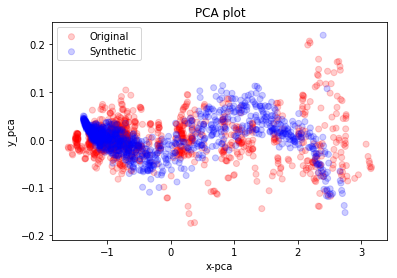

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.334s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.025786
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.527946
[t-SNE] KL divergence after 300 iterations: 0.628681


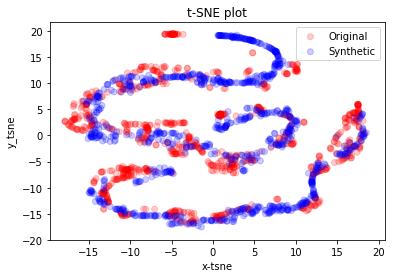

In [11]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')